In [57]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from torch import nn
plt.rcParams['figure.figsize'] = [5,3]
torch.__version__  # cuda 11.7

'1.13.1+cu117'

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
device 

'cuda'

### Create Regression Dataset

In [59]:
weight = 0.7
bias = 0.3

np.random.seed(42)
torch.cuda.manual_seed(42)

X = torch.rand(100).unsqueeze(dim = 1)

# true relationship
y = X*weight + bias + np.random.normal(scale=0.01,size = X.shape[0]).reshape(-1,1)

X.shape, y.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

### Split into train and test data

In [60]:
train_size = 0.8 # 80-20 split

np.random.seed(42)

indices = np.arange(X.shape[0])  # create and shuffle indices
np.random.shuffle(indices)

# divide train and test index
train_index, test_index =  indices[:int(len(indices)*0.8)] , indices[int(len(indices)*0.8):]

# slice X and y 
X_train, X_test = X[train_index], X[test_index]
y_train , y_test = y[train_index], y[test_index]

In [61]:
X_train.shape, y_train.shape

(torch.Size([80, 1]), torch.Size([80, 1]))

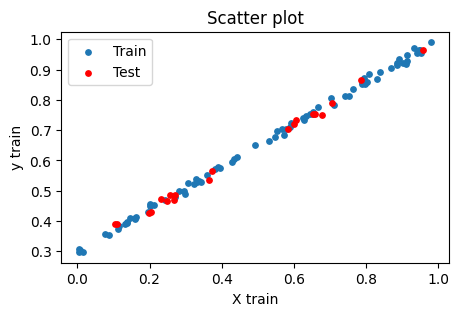

In [62]:
plt.scatter(X_train, y_train, label = 'Train', s= 15)
plt.scatter(X_test, y_test, c='r', label = 'Test', s= 15)
plt.xlabel('X train')
plt.ylabel('y train')
plt.title('Scatter plot')
plt.legend()
plt.show()

### Build a Model 

In [63]:
# define model 
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        
        # defining using the parameter method 
        self.weight = torch.nn.Parameter(torch.rand(1, device = device, requires_grad=True))
        self.bias = torch.nn.Parameter(torch.rand(1, device = device, requires_grad=True))
    
    def forward(self, X: torch.Tensor):
        # forward is like prediction 
        return X*self.weight + bias 

In [64]:
torch.manual_seed(42)
model_0 = LinearRegression()

In [65]:
# current weights
model_0.state_dict()

OrderedDict([('weight', tensor([0.6130], device='cuda:0')),
             ('bias', tensor([0.9877], device='cuda:0'))])

### Define loss function and optimizer

In [66]:
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)
loss_fn = nn.L1Loss()

### Train and Test loop 

In [67]:
train_loss = []
test_loss = []
epochs = 100

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    
    model_0.train()
    
    pred = model_0(X_train)
    
    loss = loss_fn(y_train, pred)
    
    train_loss.append(loss.item())
    optimizer.zero_grad()

    loss.backward()
    
    optimizer.step()
    
    model_0.eval() 
    with torch.inference_mode():
        pred_te = model_0(X_test)
        loss_te = loss_fn(y_test, pred_te)
        test_loss.append(loss_te.item())
    
        
    if epoch%5 ==0:
        print(epoch , loss.item(), loss_te.item())
    

0 0.04440018976322869 0.03364001652653683
5 0.031423756597321155 0.02295812770999341
10 0.018861121796146508 0.014888924526562448
15 0.008967445245053555 0.009698136317124123
20 0.0066953282095096635 0.009486060792024603
25 0.006536915333774926 0.009874529000685568
30 0.006535221136774952 0.009882066008017415
35 0.006535192079510624 0.00988961046592986
40 0.006535161904659206 0.009897148963377829
45 0.00653512874957555 0.009904685970709676
50 0.006535102300014431 0.00991223191873824
55 0.006535071007575924 0.009919773396418446
60 0.0065350412052535365 0.009927305933401936
65 0.006535011402931149 0.009934848901198263
70 0.00653498532589906 0.009942387398646231
75 0.0065350624394082376 0.009921591338084096
80 0.006535035244789059 0.009929135795996542
85 0.006535002462234433 0.00993667429344451
90 0.0065350552995888074 0.009915882703230733
95 0.00653505834158891 0.009923421200678701


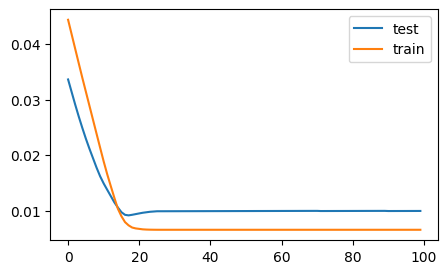

In [68]:
plt.plot(list(range(epochs)), test_loss, label = 'test')
plt.plot(list(range(epochs)), train_loss, label = 'train')
plt.legend()
plt.show()

#### Check tuned weights 

In [69]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6997], device='cuda:0')),
             ('bias', tensor([0.9877], device='cuda:0'))])

### Prediction

In [70]:
model_0.eval()
with torch.inference_mode():
    t_pred = model_0(X_test.to(device))

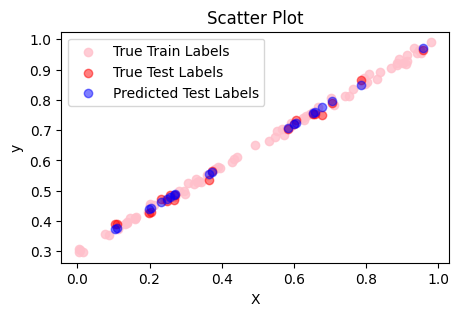

In [71]:
plt.scatter(X_train.cpu(), y_train.cpu(), alpha = 0.8,c ='pink', label='True Train Labels')
plt.scatter(X_test.cpu(), y_test.cpu(), alpha = 0.5,c ='r', label='True Test Labels')
plt.scatter(X_test.cpu(), t_pred.detach().cpu(),c='b', alpha = 0.5, label = 'Predicted Test Labels')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Scatter Plot')
plt.show()

### Saving and loading the model

In [72]:
from pathlib import Path

# Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path 
MODEL_NAME = "model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\model_0.pth


In [73]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegression()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [74]:
loaded_model_0.to(device)

LinearRegression()

In [75]:
# check device of loaded model
next(loaded_model_0.parameters())

Parameter containing:
tensor([0.6997], device='cuda:0', requires_grad=True)

In [76]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [77]:
loaded_model_preds == t_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')